# Exploratory Data Analysis for Acoustic Anomaly Detection
#
This notebook analyzes three audio recordings:
- A **complete recording** that contains all sounds including anomalies,
- An **anomalous recording** that includes only the anomalous segments,
- A **normal recording** that has been "cleaned" for training.
#
In this analysis we extract and visualize various features:
- **Time-domain**: Raw waveform.
- **Frequency-domain**: Mel-spectrogram, FFT.
- **Time-frequency**: STFT spectrogram.
- **Multi-resolution**: Wavelet transform.
- **High-level features**: MFCCs and other features extracted individually.
#
These analyses help reveal both global and local characteristics of the signals for anomaly detection.


## 1. Imports and Setup


In [2]:
#!pip install PyWavelets

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft
import seaborn as sns
from matplotlib import ticker
import pywt

# Global plot settings
plt.rcParams.update({'font.size': 10})
sns.set(style="whitegrid")


## 2. Utility Functions
#
Here we define helper functions for:
- Loading audio files.
- Generating Mel-spectrograms and plotting waveforms.
- Individually extracting features: MFCCs, spectral centroid, spectral rolloff, spectral contrast, and zero crossing rate.
- Computing FFT, STFT, and Wavelet transforms.


In [4]:
def load_audio_file(file_path, label):
    """Load a .wav file and return the audio signal, label, and sample rate."""
    if os.path.isfile(file_path) and file_path.endswith('.wav'):
        audio, sr = librosa.load(file_path, sr=None)
        return audio, label, sr
    else:
        raise ValueError(f"Invalid .wav file: {file_path}")


In [5]:
def generate_mel_spectrogram(audio, sr, n_mels=128, n_fft=1024, hop_length=512):
    """
    Generate a normalized Mel-spectrogram from an audio signal.
    Normalization scales the decibel values between 0 and 1.
    """
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)) ** 2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_norm


In [6]:
def plot_waveform(audio, sr, title="Waveform"):
    """Plot the raw audio waveform."""
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


In [7]:
def plot_mel_spectrogram(mel_spec, sr, title="Mel-Spectrogram", xlim=None, nbins=15, save_path=None):
    """Plot a Mel-spectrogram with time formatted as MM:SS."""
    fig, ax = plt.subplots(figsize=(10, 6))
    img = librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
    ax.set(title=title, xlabel='Time (s)', ylabel='Frequency (Hz)')
    if xlim:
        ax.set_xlim(xlim)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x // 60):02d}:{int(x % 60):02d}"))
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [8]:
# Individual Feature Extraction Functions

def extract_mfccs(audio, sr, n_mfcc=13):
    """
    Extract MFCCs from the audio.
    Returns the full MFCC matrix (n_mfcc x time_frames).
    """
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def extract_spectral_centroid(audio, sr):
    """Extract the spectral centroid."""
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    return centroid

def extract_spectral_rolloff(audio, sr):
    """Extract the spectral rolloff."""
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    return rolloff

def extract_spectral_contrast(audio, sr):
    """Extract the spectral contrast."""
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    return contrast

def extract_zero_crossing_rate(audio):
    """Extract the zero-crossing rate."""
    zcr = librosa.feature.zero_crossing_rate(audio)
    return zcr


In [9]:
# Additional Transformations

def compute_fft(audio, sr):
    """
    Compute FFT of the audio signal and return frequencies and amplitude spectrum.
    Also plots the FFT amplitude spectrum.
    """
    N = len(audio)
    yf = fft(audio)
    xf = np.linspace(0.0, sr / 2, N // 2)
    amplitudes = 2.0 / N * np.abs(yf[:N // 2])

    plt.figure(figsize=(10, 4))
    plt.plot(xf, amplitudes)
    plt.title("FFT Amplitude Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return xf, amplitudes

def compute_stft(audio, sr, n_fft=1024, hop_length=512):
    """
    Compute and display the Short-Time Fourier Transform (STFT) spectrogram.
    """
    stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length, cmap='viridis')
    plt.title("STFT Spectrogram (Log-Frequency)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    return stft_result

def compute_wavelet(audio, wavelet='db4', level=5):
    """
    Compute the Discrete Wavelet Transform of the audio signal.
    Plots the wavelet coefficients for each level.
    """
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    plt.figure(figsize=(12, 8))
    for i, coeff in enumerate(coeffs):
        plt.subplot(len(coeffs), 1, i + 1)
        plt.plot(coeff)
        plt.title(f"Wavelet Coefficients Level {i}")
        plt.xlabel("Coefficient Index")
        plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

    return coeffs


## 3. Data Loading
#
We load the three provided audio recordings:
- **Complete**: Contains all sounds including anomalies.
- **Anomalous**: Contains only the anomalous segments.
- **Normal**: The cleaned recording (concatenated and anomaly-free).
#
Each file is loaded only once.


In [10]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

# Uncomment and adjust the following lines if needed:
#%cd drive/MyDrive/
#%ls

# Define paths to the audio files
#path_complete = "output_MIC1_2024-11-07_13-55-00_065414.wav"
#path_anomaly  = "Anomaly_knackgeräusche.wav"
#path_normal   = "Normal_knackgeräusche.wav"

# Define paths to the audio files
path_anomaly = "../../Data/raw/12_wm/A_12_wm.wav"
path_normal = "../../Data/raw/12_wm/N_12_wm.wav"

# Load the recordings
audio_anomaly, _, sr_anomaly   = load_audio_file(path_anomaly, label="Anomalous")
audio_normal, _, sr_normal     = load_audio_file(path_normal, label="Normal")

print(f"Anomalous: {len(audio_anomaly)} samples at {sr_anomaly} Hz")
print(f"Normal: {len(audio_normal)} samples at {sr_normal} Hz")

# Ensure sampling rates match for anomaly and normal recordings
assert sr_anomaly == sr_normal, "Sampling rates for anomaly and normal recordings do not match!"


Anomalous: 3818262 samples at 44100 Hz
Normal: 52467886 samples at 44100 Hz


## 4. Visualization: Raw Audio and Mel-Spectrograms


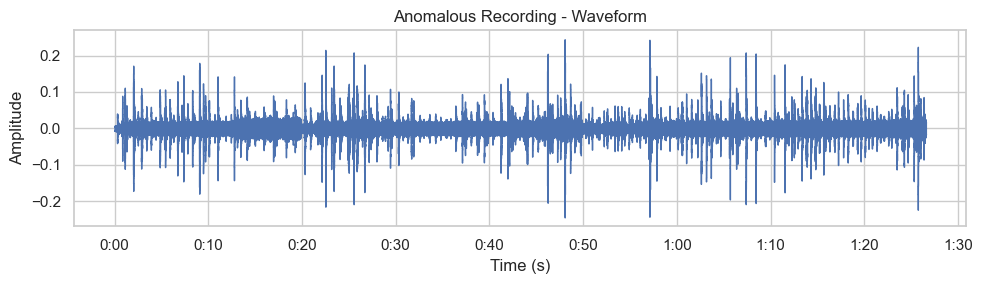

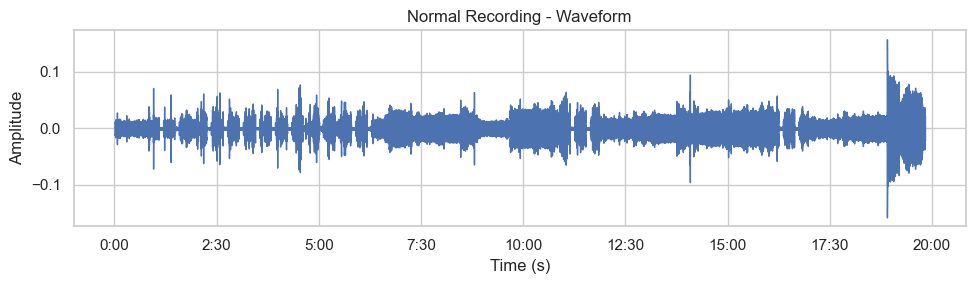

In [11]:
# Plot raw waveforms
plot_waveform(audio_anomaly, sr_anomaly, title="Anomalous Recording - Waveform")
plot_waveform(audio_normal, sr_normal, title="Normal Recording - Waveform")


In [12]:
# Generate Mel-spectrograms
mel_anomaly  = generate_mel_spectrogram(audio_anomaly, sr_anomaly)
mel_normal   = generate_mel_spectrogram(audio_normal, sr_normal)


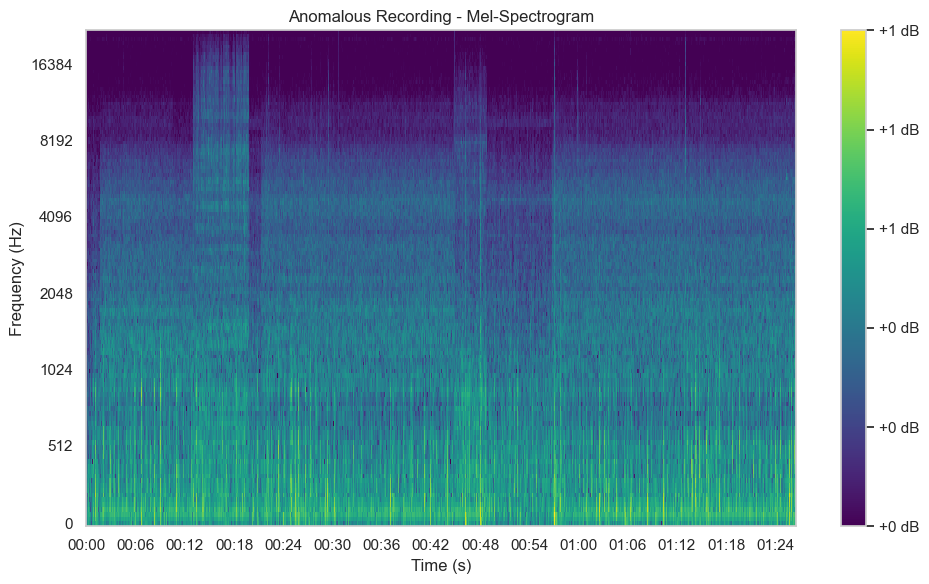

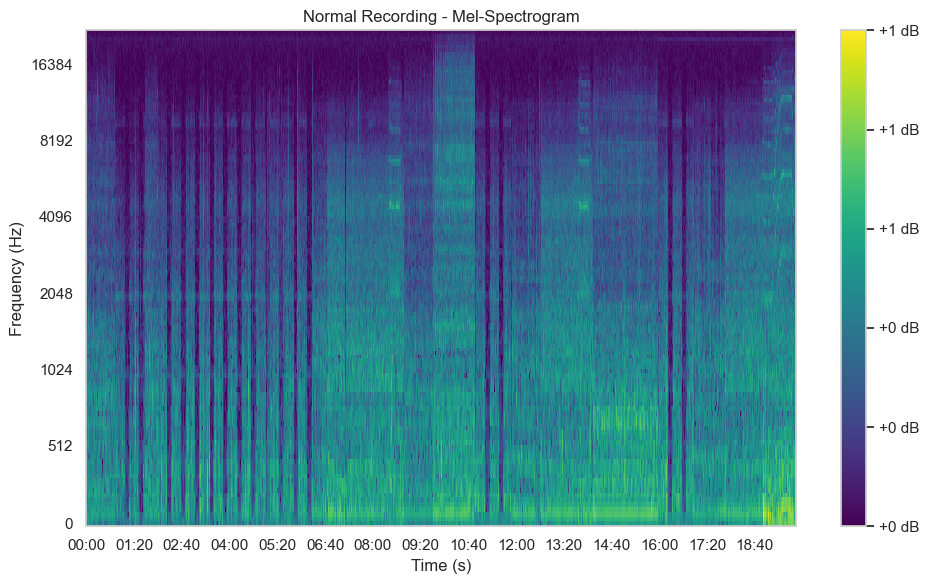

In [13]:
# Plot Mel-spectrograms
plot_mel_spectrogram(mel_anomaly, sr_anomaly, title="Anomalous Recording - Mel-Spectrogram")
plot_mel_spectrogram(mel_normal, sr_normal, title="Normal Recording - Mel-Spectrogram")


## 5. Individual Feature Extraction
#
Here we extract individual features from the audio.
We'll extract:
- **MFCCs**
- **Spectral Centroid**
- **Spectral Rolloff**
- **Spectral Contrast**
- **Zero Crossing Rate**
#
For MFCCs, we print the full matrix shape and also the mean across time.


In [14]:
# MFCCs
mfccs_anomaly   = extract_mfccs(audio_anomaly, sr_anomaly, n_mfcc=13)
mfccs_normal    = extract_mfccs(audio_normal, sr_normal, n_mfcc=13)

print("MFCCs shape (Anomalous):", mfccs_anomaly.shape)
print("MFCCs shape (Normal):", mfccs_normal.shape)

mfccs_anomaly_mean  = np.mean(mfccs_anomaly, axis=1)
mfccs_normal_mean   = np.mean(mfccs_normal, axis=1)

print("MFCCs mean (Anomalous):", mfccs_anomaly_mean)
print("MFCCs mean (Normal):", mfccs_normal_mean)


MFCCs shape (Anomalous): (13, 7458)
MFCCs shape (Normal): (13, 102477)
MFCCs mean (Anomalous): [-388.2646     151.39424    -21.650507    33.96916      1.652228
    5.1285615   15.40483      4.6441097   -1.3385488    3.2199252
    0.8529399   -4.490417     2.6487536]
MFCCs mean (Normal): [-4.4002792e+02  1.3091762e+02 -7.7147870e+00  2.4457169e+01
 -3.1321266e+00  4.5183144e+00  8.8430967e+00  4.9421158e+00
 -3.6949700e-01  3.1361380e+00  2.3663888e+00 -3.2505686e+00
  2.4114451e+00]


####Complete Recording (Top Figure, ~20 min):
You can see multiple changes in the color bands over the 20-minute span. Each horizontal “stripe” corresponds to one of the 13 MFCC coefficients, and the color indicates its magnitude at each time step.
The fact that some stripes transition from red to blue (or vice versa) at certain times suggests that the spectral envelope of the machine sound is shifting—possibly reflecting changes in operating mode or the appearance of short anomalous events.
The large timescale also means you’ll see broader patterns that might average out many short-term anomalies but still highlight any major shifts in the machine’s acoustic profile.
####Anomalous Recording (Middle Figure, ~5.4 min):
This plot is much shorter in duration. You can see that certain MFCC coefficients (particular horizontal bands) may exhibit more frequent changes (patches of different colors) within this shorter time window.
Since this recording isolates anomalous events, the MFCCs might show higher variability or distinct patterns compared to a steady-state normal operation. Look for sudden color shifts or banding that differs from the normal recording.
####Normal Recording (Bottom Figure, ~58 min):
Despite being the longest clip (nearly an hour), it appears quite uniform in its color distribution, indicating a relatively stable spectral profile over time.
The strong red (or consistently high) band near the bottom suggests that one or more MFCC coefficients are consistently large (possibly reflecting the dominant spectral shape of the machine in normal operation).
The overall consistency (fewer abrupt color changes) aligns with the idea that the machine is running normally without major acoustic disturbances or anomalies.
####Overall Observations
Stability vs. Variability:
The normal recording is mostly uniform, reflecting stable machine noise. The anomalous recording, being shorter, highlights more abrupt or higher-frequency changes in the MFCCs (depending on the anomaly type). The complete recording includes a mixture of normal operation and sporadic anomalies or mode changes, so you see periodic shifts or band changes at certain timestamps.

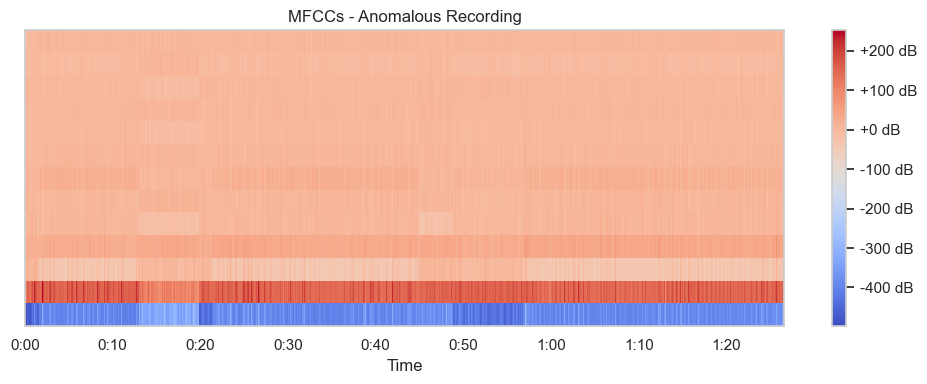

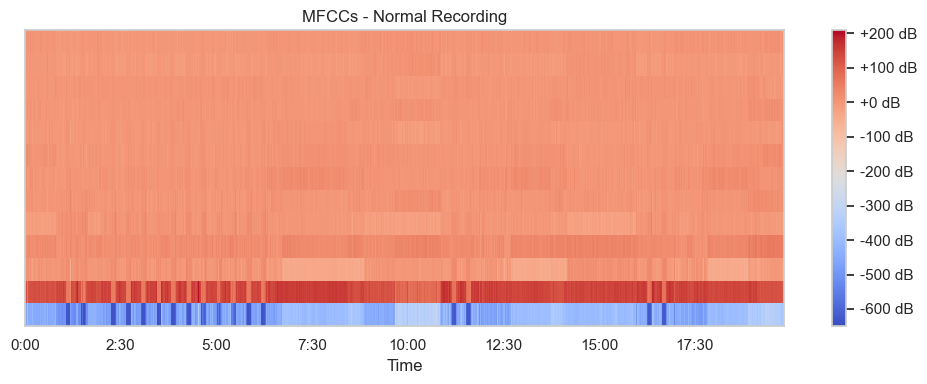

In [15]:
# Visualize MFCCs for the Anomalous recording
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_anomaly, sr=sr_anomaly, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs - Anomalous Recording')
plt.tight_layout()
plt.show()

# Visualize MFCCs for the Normal recording
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_normal, sr=sr_normal, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs - Normal Recording')
plt.tight_layout()
plt.show()


Spectral centroid (SC) measures the shape of the spectrum of EEG signals. A higher value of SC corresponds to more energy of the signal being concentrated within higher frequencies. Basically, it measures the spectral shape and position of the spectrum. [Source](https://www.sciencedirect.com/topics/engineering/spectral-centroid). In this case it can be seen that the Anomalous Audios has a higher score, indicating potential anomalies.

In [16]:
# Spectral Centroid
centroid_anomaly  = extract_spectral_centroid(audio_anomaly, sr_anomaly)
centroid_normal   = extract_spectral_centroid(audio_normal, sr_normal)

print("Spectral Centroid Mean (Anomalous):", np.mean(centroid_anomaly))
print("Spectral Centroid Mean (Normal):", np.mean(centroid_normal))


Spectral Centroid Mean (Anomalous): 2607.0236091599727
Spectral Centroid Mean (Normal): 3513.9566100624393


Spectral rolloff indicates the frequency below which a certain percentage (typically 85% or 95%) of the total spectral energy is contained. In practical terms, a higher spectral rolloff means that more energy is present at higher frequencies.

In [17]:
# Spectral Rolloff
rolloff_anomaly  = extract_spectral_rolloff(audio_anomaly, sr_anomaly)
rolloff_normal   = extract_spectral_rolloff(audio_normal, sr_normal)

print("Spectral Rolloff Mean (Anomalous):", np.mean(rolloff_anomaly))
print("Spectral Rolloff Mean (Normal):", np.mean(rolloff_normal))


Spectral Rolloff Mean (Anomalous): 5234.667399154013
Spectral Rolloff Mean (Normal): 7419.393240754633


In [18]:
# Spectral Contrast - not very insightful - could delete
contrast_anomaly  = extract_spectral_contrast(audio_anomaly, sr_anomaly)
contrast_normal   = extract_spectral_contrast(audio_normal, sr_normal)

print("Spectral Contrast Mean (Anomalous):", np.mean(contrast_anomaly, axis=1))
print("Spectral Contrast Mean (Normal):", np.mean(contrast_normal, axis=1))


Spectral Contrast Mean (Anomalous): [14.62486115  8.2271779  11.88419999 13.39505396 13.82048067 14.99265047
 20.15582963]
Spectral Contrast Mean (Normal): [14.40103063  8.29929044 11.71473597 13.82368543 14.6192945  15.43166802
 18.80084524]


In [19]:
# Zero Crossing Rate - not very insightful - could delete
zcr_anomaly  = extract_zero_crossing_rate(audio_anomaly)
zcr_normal   = extract_zero_crossing_rate(audio_normal)

print("Zero Crossing Rate Mean (Anomalous):", np.mean(zcr_anomaly))
print("Zero Crossing Rate Mean (Normal):", np.mean(zcr_normal))


Zero Crossing Rate Mean (Anomalous): 0.04948394603529767
Zero Crossing Rate Mean (Normal): 0.06877973895209413


## 6. Additional Transform Analyses: FFT, STFT, and Wavelet Transform


FFT Analysis for Anomalous Recording:


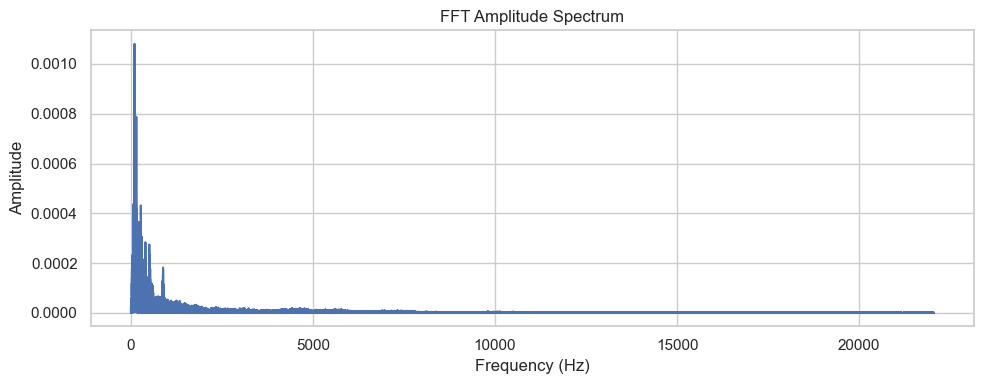

FFT Analysis for Normal Recording:


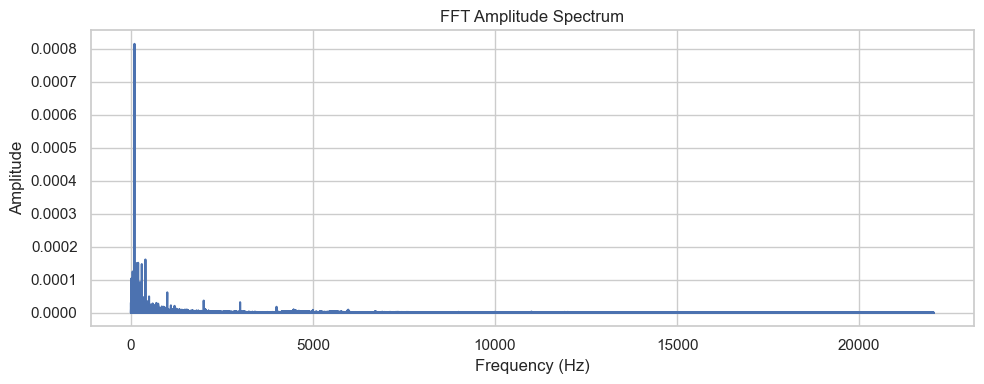

In [20]:
# FFT Analysis
print("FFT Analysis for Anomalous Recording:")
xf_anomaly, amplitudes_anomaly = compute_fft(audio_anomaly, sr_anomaly)
print("FFT Analysis for Normal Recording:")
xf_normal, amplitudes_normal = compute_fft(audio_normal, sr_normal)


STFT for Anomalous Recording:


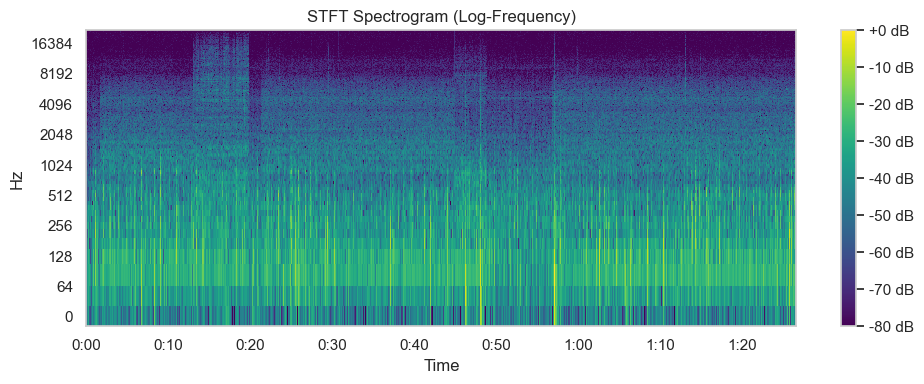

STFT for Normal Recording:


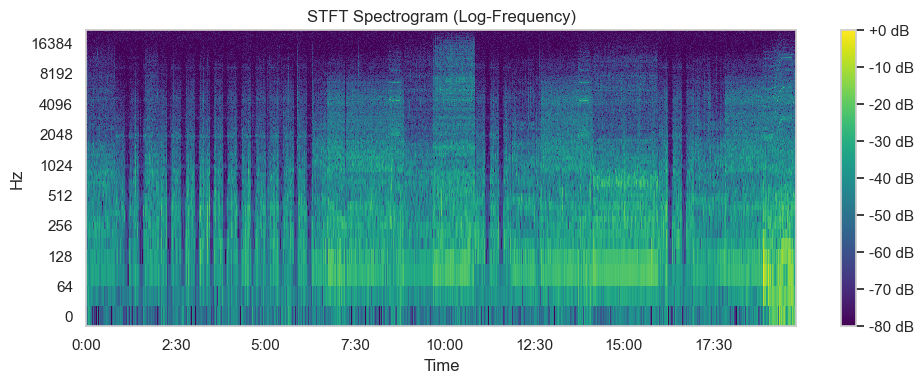

In [21]:
# STFT Analysis
print("STFT for Anomalous Recording:")
stft_anomaly = compute_stft(audio_anomaly, sr_anomaly)
print("STFT for Normal Recording:")
stft_normal = compute_stft(audio_normal, sr_normal)


Wavelet Transform for Anomalous Recording:


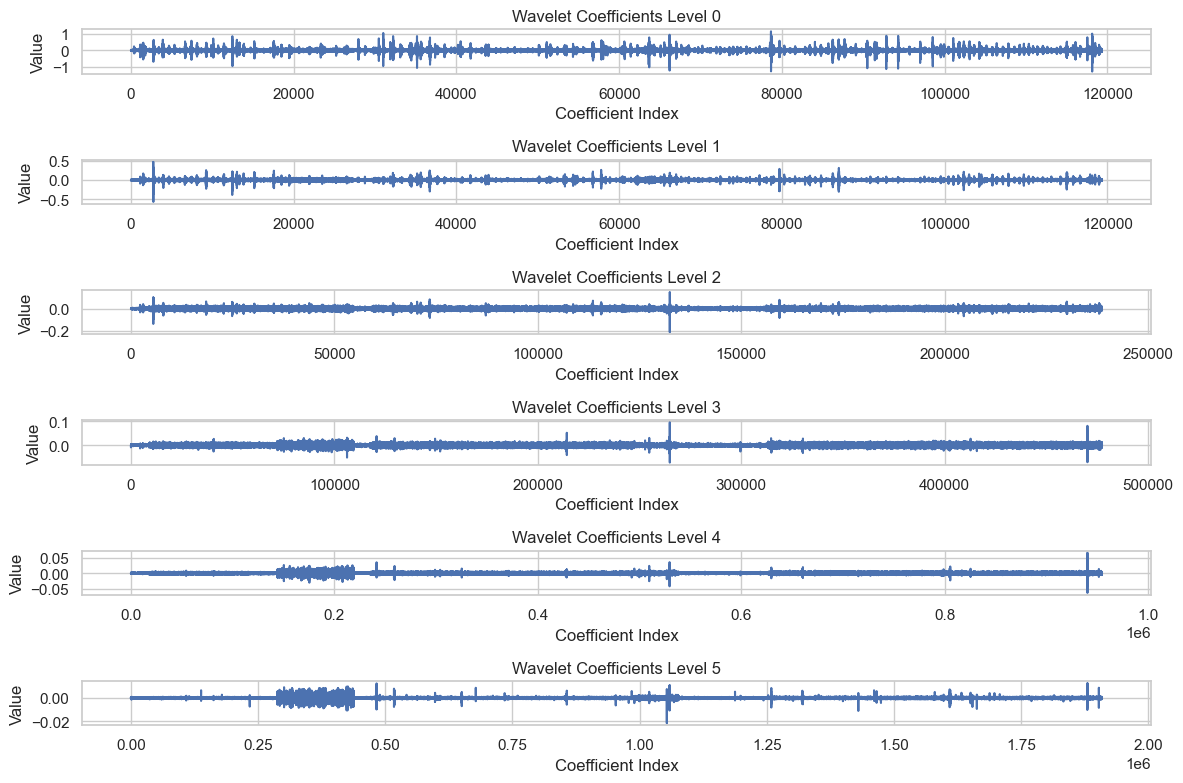

Wavelet Transform for Normal Recording:


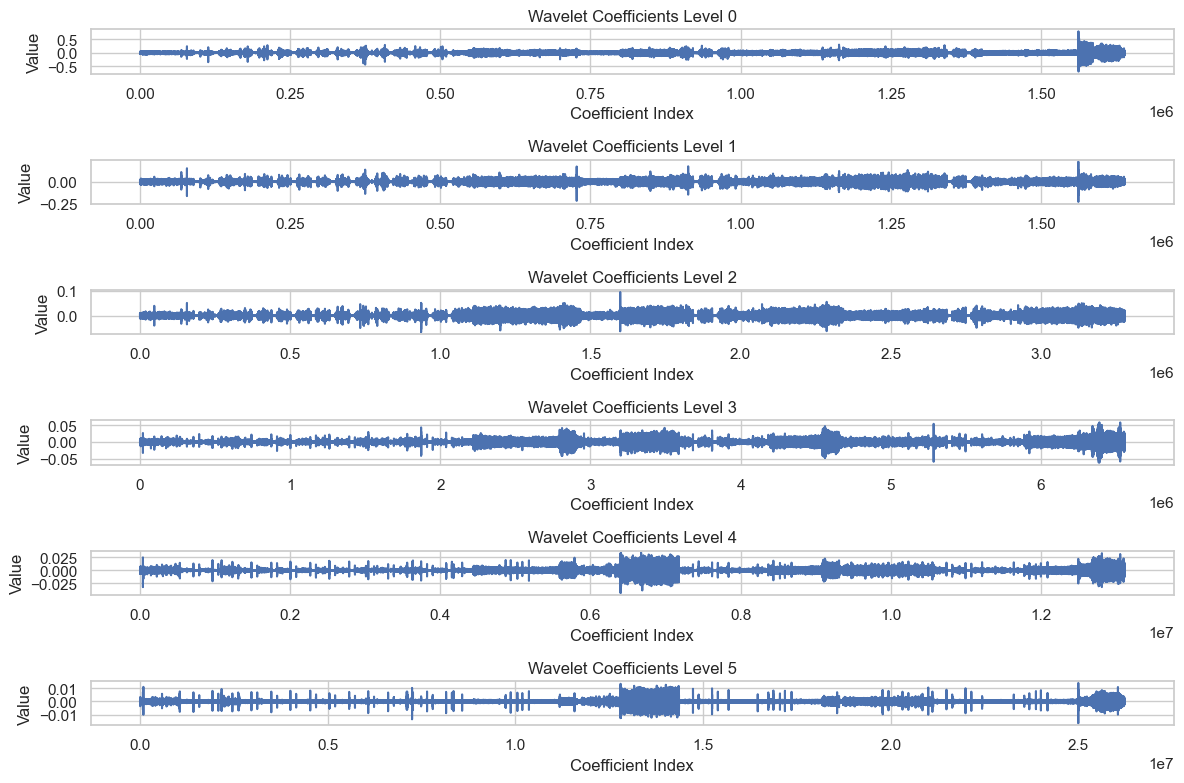

In [22]:
# Wavelet Transform Analysis
print("Wavelet Transform for Anomalous Recording:")
coeffs_anomaly = compute_wavelet(audio_anomaly, wavelet='db4', level=5)
print("Wavelet Transform for Normal Recording:")
coeffs_normal = compute_wavelet(audio_normal, wavelet='db4', level=5)


## 7. Observations and Conclusions
#
- The raw waveforms and Mel-spectrograms reveal distinct patterns between the complete, anomalous, and normal recordings.
- Individual feature extraction now separately computes MFCCs, spectral metrics, and zero-crossing rate.
- FFT, STFT, and wavelet transform analyses offer complementary insights:
  - **FFT** exposes dominant frequency content.
  - **STFT** reveals time-varying spectral patterns.
  - **Wavelet Transform** captures multi-resolution, transient events.
#
These analyses collectively lay the groundwork for further modeling and anomaly detection.
